In [99]:
using FFTW, Plots, LinearAlgebra, SparseArrays, Printf, Plots, CSV, DataFrames
import Base: diff

# Trogdon Code
rnd = xx -> map(x -> round(x, digits = 5),xx)
mfftshift = x -> circshift(fftshift(x), isodd(length(x)) ? 1 : 0)
mfft = x -> fftshift(fft(fftshift(x),1)) # fft(x,1) is used so that
# when we operate on matrices below, the behavior is as desired.
mifft = x -> mfftshift(ifft(mfftshift(x),1))
mgrid = (n,L) -> -L .+ 2*L*(0:n-1)/n # array from -L to L leaving out L

F = c -> (-6) .* mfft(mifft(c) .* mifft(D*c))

#449 (generic function with 1 method)

## Functions

In [100]:
function rk4(a, t, dt) 
    f1 = exp(D.^3 * t) * F(exp(-D.^3 * t) * a)
    f2 = exp(D.^3 * (t+dt/2)) * F(exp(-D.^3 * (t+dt/2)) * (a+(dt/2)*f1))
    f3 = exp(D.^3 * (t+dt/2)) * F(exp(-D.^3 * (t+dt/2)) * (a+(dt/2)*f2))
    f4 = exp(D.^3 * (t+dt)) * F(exp(-D.^3 * (t+dt)) * (a+dt*f3))
    a = a + (dt/6)*(f1+2*f2+2*f3+f4)
    return a
end

rk4 (generic function with 1 method)

In [101]:
function CG(A,b,eps::Float64)
   x = 0.0*b; r = b; p = r; n = 0;
   while norm(r) > eps
        q = A(p)
        a = (r'*r)/(p'*q)
        x += a*p
        r_old = r
        r += - a*q
        b = (r'*r)/(r_old'*r_old)
        p = r + b*p 
        n += 1
    end
    x
end

CG (generic function with 1 method)

In [102]:
struct trig_interp
    L::Float64
    c::Vector{Complex{Float64}}
end

function (tr::trig_interp)(x) # just sums the Fourier series!
    m = length(tr.c)
    mm = convert(Int64,floor( m/2 ))
    σ = isodd(m) ? 1im*pi/m : 0. # if n is odd we need to rotate coefs
    ex = exp.(-1im*pi*mm*x/tr.L + mm*σ)
    ex1 = exp.(1im*pi*x/tr.L-σ)
    sum = tr.c[1]*ex
    for i = 2:length(tr.c)
        ex  =  ex.*ex1
        sum += tr.c[i]*ex
    end
    return sum/m
end   

## Data

In [5]:
# T = 5, one soliton
data = Array(CSV.read("out.csv", DataFrame))
x_vals = data[:,1]
true_sol = data[:,2];

In [6]:
# T = 5, two solitons
data = Array(CSV.read("out-new.csv", DataFrame))
x_vals = data[:,1]
true_sol = data[:,2];

In [7]:
# T = 50, one soliton
data = Array(CSV.read("out-longtime-50.csv", DataFrame))
x_vals = data[:,1]
true_sol = data[:,2];

In [103]:
# T = 150, one soliton
data = Array(CSV.read("out-longtime-150.csv", DataFrame))
x_vals = data[:,1]
true_sol = data[:,2];

## Periodic Problem

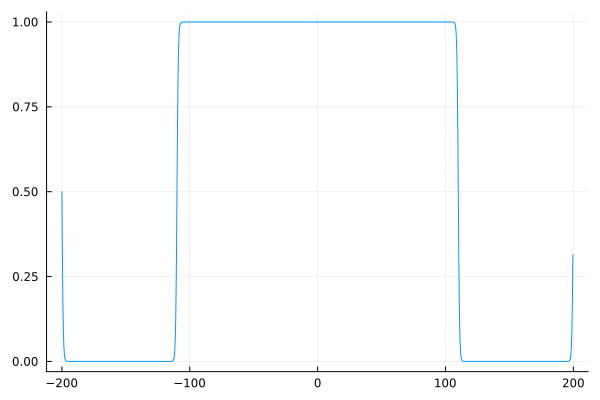

In [36]:
x_vals = mgrid(2^14, 300)

L = 200
m = 2^10
X = mgrid(m,L)

if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end
D = (pi/L) * Diagonal(1im.*n)

ℓ1 = -L + (L/2) - 10
ℓ2 = L
σ = x -> 1 .- (0.5.*(tanh.((x.-ℓ1)) .+ 1) + 0.5.*(tanh.((-x.-ℓ2)) .+ 1))
γ = x -> 1 .- σ(-x) .- σ(x)

Σ = Diagonal(σ(X))
A = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x))
B = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x))
Plots.plot(X,γ(X),label = false)

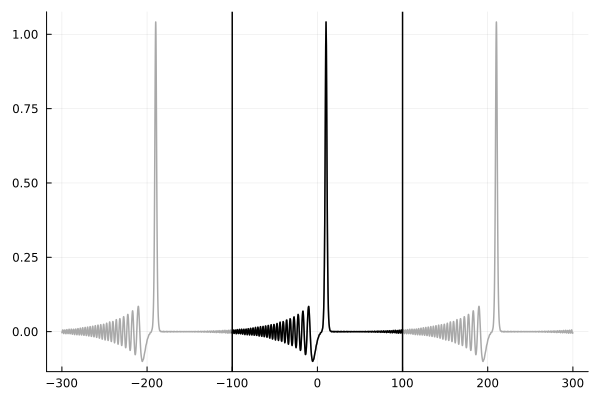

In [33]:
u = x -> 1.3*exp.(-x.^2)
c = mfft(u(X))
dt = 0.01
T = 5.0
t = 0.0
steps = convert(Int64,ceil(T/dt));

for i = 1:steps
    a = rk4(c, 0, dt)
    c = exp(-D.^3*dt) * a
    t += dt
end

fm = trig_interp(L,c)
undamped_sol = map(fm,x_vals) |> real;

plot(x_vals, undamped_sol, label = false, line = :darkgrey, linewidth = 1.5)
plot!([-L,L], seriestype = :vline, line = :black, label = false, linewidth = 1.5)
#plot!([-45,45], seriestype = :vline, line = :red, label = false)
plot!(X,mifft(c) |> real, label = false, line = :black, linewidth = 1.5)

In [34]:
savefig("fourierproblem.pdf")

"/Users/annieliu/Library/CloudStorage/Dropbox/Mac/Documents/Artificial Boundary Conditions/fourierproblem.pdf"

## Undamped solution

In [112]:
L = 1200
m = 2^13
X = mgrid(m,L)

if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end
D = (pi/L) * Diagonal(1im.*n)

u = x -> 1.3*exp.(-x.^2)
c = mfft(u(X))
dt = 0.01
T = 150.0
t = 0.0
steps = convert(Int64,ceil(T/dt));

@time begin

for i = 1:steps
    a = rk4(c,0,dt)
    c = exp(-D.^3*dt) * a
    t += dt
end

fm = trig_interp(L,c)
undamped_sol = map(fm,x_vals) |> real;

end

error = maximum(abs.(true_sol .- undamped_sol))

 35.241553 seconds (9.22 M allocations: 212.792 GiB, 4.66% gc time)


0.0024073596003685496

In [46]:
ϵ = 10^(-3);
errors = abs.(undamped_sol .- true_sol) |> rnd

i = 1;
j = 1;
k = 1;
plots = 0;
Plots.plot(x_vals, true_sol, line = :black, linewidth = 0.8, label = "true solution", yaxis=[-0.2,1])

while j < length(errors)  
    i = k;
    while errors[i] > ϵ && i < length(errors)
        i += 1
    end
    
    k = i;
    
    if i != length(errors)
        x_min = x_vals[i];
        
        while errors[k] < ϵ && k < length(errors)
            k += 1
        end
        x_max = x_vals[k];
        
        if (x_max - x_min) > 10
            if plots == 0
                Plots.plot!(x_vals[j:i], undamped_sol[j:i], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = false)
                Plots.plot!(x_vals[i:k], undamped_sol[i:k], fill = (-0.2,:lavender), line = :lavender, linewidth = 1.5, label = "undamped solution")
                #plot!([x_min,x_max], seriestype = :vline, line = :red, label = false, xticks = [Int(round(x_min)),Int(round(x_max)),0])
            else
                Plots.plot!(x_vals[j:i], undamped_sol[j:i], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = false)
                Plots.plot!(x_vals[i:k], undamped_sol[i:k], fill = (-0.2,:lavender), line = :lavender, linewidth = 1.5, label = false)
                #plot!([x_min,x_max], seriestype = :vline, line = :red, label = false, xticks = [Int(round(x_min)),Int(round(x_max)),0])
            end
            plots = 1;
        else
            Plots.plot!(x_vals[j:k], undamped_sol[j:k], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = false)
        end
    else
        Plots.plot!(x_vals[j:k], undamped_sol[j:k], fill = (-0.2,:lightgrey), line = :lightgrey, linewidth = 1.5, label = "undamped solution")
    end
    j = k;
end

Plots.plot!(x_vals, true_sol, line = :black, linewidth = 0.8, label = false)
savefig("undampedgood.pdf")

"/Users/annieliu/Library/CloudStorage/Dropbox/Mac/Documents/Artificial Boundary Conditions/undampedgood.pdf"

## Damped solution

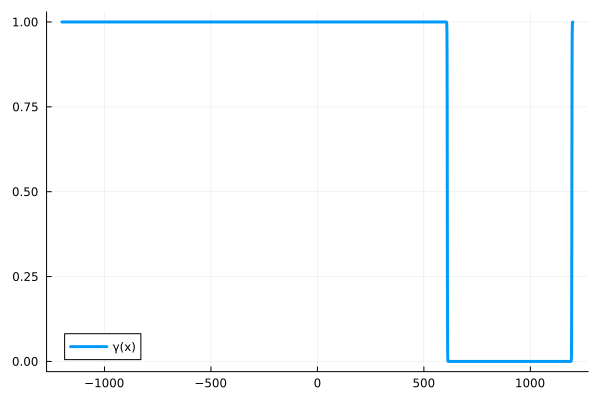

In [113]:
L = 1200
m = 2^13
X = mgrid(m,L)

if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end
D = (pi/L) * Diagonal(1im.*n)

k_1 = 1

ℓ1 = -L + (L/2) - 10
ℓ2 = L - 5
σ1 = x -> 1 .- (0.5.*(tanh.((x.-ℓ1)) .+ 1) + 0.5.*(tanh.((-x.-ℓ2)) .+ 1))
σ2 = x -> σ1(x) .+ σ1(-x)
γ = x -> 1 .- σ1(-x)
σ = x -> k_1 * σ1(x)

Σ = Diagonal(σ(X))
A = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x))
B = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x))
Plots.plot(X,γ(X),label = "γ(x)", linewidth = 3)
#savefig("fig4.pdf")

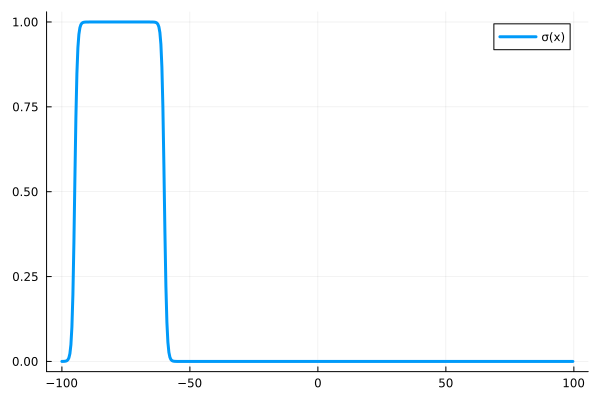

In [106]:
Plots.plot(X,σ(X),label = "σ(x)", linewidth = 3)
#savefig("fig3.pdf")

In [114]:
f_2 = 1000

u = x -> 1.3*exp.(-x.^2)
c = mfft(u(X))
dt = 0.01
T = 150.0
t = 0.0
steps = convert(Int64,ceil(T/dt))

f_1 = 1
a = c

@time begin

for i = 2:steps+1
        # sigma damping
        if isinteger(i / f_1)
            a = rk4(c,0,dt/2)
            c_til = exp(-D.^3*dt/2) * a
            c_bar = CG(B, A(c_til), 1e-10)
            a = rk4(c_bar,0,dt/2)
            c = exp(-D.^3*dt/2) * a 
        else
            a = rk4(c,0,dt)
            c = exp(-D.^3*dt) * a
        end
            
        # gamma damping
        if isinteger(i / f_2)
            func_vals = mifft(c) .* γ(X)
            c = mfft(func_vals)
        end
    #end           
    t += dt
end

fm = trig_interp(L,c)
my_sol = map(fm,x_vals) |> real
    
end

error = maximum(abs.(true_sol .- my_sol))

299.440622 seconds (31.37 M allocations: 730.705 GiB, 1.86% gc time, 0.01% compilation time)


4.26045905187189e-8

In [77]:
plot(X,mifft(c) |> real,xaxis=[-500,480],grid=false,label=false,axis = false)
savefig("fig1.pdf")

"/Users/annieliu/Library/CloudStorage/Dropbox/Mac/Documents/Artificial Boundary Conditions/fig1.pdf"

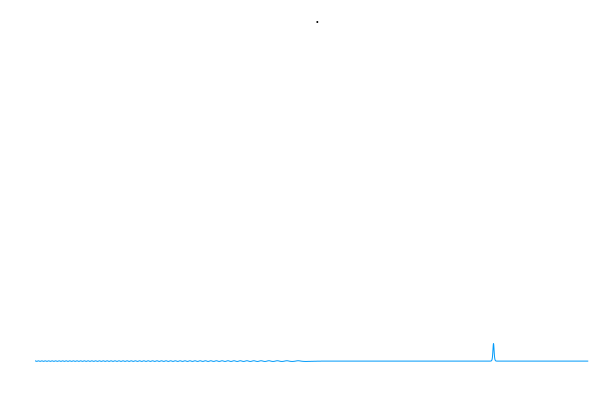

In [75]:
plot(X,mifft(c) |> real,xaxis=[-500,480],grid=false,label=false,axis=false)
plot!([0,0],[20,20],arrow=true,color=:black,linewidth=2,label="")

In [30]:
# try with regular splitting instead of Strang:
f_2 = 1000

u = x -> 1.3*exp.(-x.^2)
c = mfft(u(X))
dt = 0.01
T = 150.0
t = 0.0
steps = convert(Int64,ceil(T/dt))

f_1 = 1
a = c

@time begin

for i = 2:steps+1
        a = rk4(c,0,dt)
        c = exp(-D.^3*dt) * a
        
        if isinteger(i / f_1)
            c = CG(B, A(c), 1e-10)
        end
            
        # delete the RHS
        if isinteger(i / f_2)
            func_vals = mifft(c) .* γ(X)
            c = mfft(func_vals)
        end
    #end           
    t += dt
end

fm = trig_interp(L,c)
my_sol = map(fm,x_vals) |> real
    
end

error = maximum(abs.(true_sol .- my_sol))

153.427368 seconds (24.25 M allocations: 516.666 GiB, 10.13% gc time, 0.04% compilation time)


1.326053499332367e-6

## A note on damping parameters

### Plot 1

In [67]:
# k_1 = 1, f_1 = 1, f_2 = 1000
set1 = abs.(true_sol .- my_sol);

In [72]:
# k_1 = 10, f_1 = 100, f_2 = 1000
set2 = abs.(true_sol .- my_sol);

In [77]:
# k_1 = 20, f_1 = 100, f_2 = 1000
set3 = abs.(true_sol .- my_sol);

In [251]:
# k_1 = 200, f_1 = 400, f_2 = 1000
set7 = abs.(true_sol .- my_sol);

### Plot 2

In [81]:
# k_1 = 0, f_2 = 500 (gamma is even)
set4 = abs.(true_sol .- my_sol);

In [85]:
# k_1 = 0, f_2 = 1000 (gamma is even)
set5 = abs.(true_sol .- my_sol);

In [88]:
# k_1 = 0, f_2 = 2000
set6 = abs.(true_sol .- my_sol);

In [181]:
# CairoMakie plot
size_inches = (10, 6)
size_pt = 72 .* size_inches
fig = Figure(resolution = size_pt, fontsize = 12)
ax = Axis(fig[1,1])
ax.xlabel = "x"
ax.ylabel = "Error"
lines!(ax, new_x_vals, set1 |> real, label = L"k_1 = 1,\; f_1 = 1,\; f_2 = 1000", color = :black)
lines!(ax, new_x_vals, set2 |> real, label = L"k_1 = 10,\; f_1 = 100,\; f_2 = 1000", aspect_ratio = 90, color = :green)
lines!(ax, new_x_vals, set3 |> real, label = L"k_1 = 20,\; f_1 = 100,\; f_2 = 500", color = :plum1)
lines!(ax, new_x_vals, set4 |> real, label = L"k_1 = 50,\; f_1 = 200,\; f_2 = 1000,\; \mathrm{even}\; \gamma(x)", color = :red)
lines!(ax, new_x_vals, set5 |> real, label = L"k_1 = 100,\; f_1 = 500,\; f_2 = 1000,\; \mathrm{even}\; \gamma(x)", color = :blue)
lines!(ax, new_x_vals, set6 |> real, label = L"k_1 = 0,\; f_2 = 1000,\; \mathrm{even}\; \gamma(x)", color = :darkorange)
axislegend(ax; labelsize = 13)
fig
save("diffparams.pdf", fig, pt_per_unit = 1)

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x000000008e0cc860, 720.0, 432.0, IOContext(IOStream(<file C:\Users\annie\Dropbox\ArtificialBoundaryConditions\diffparams.pdf>)))


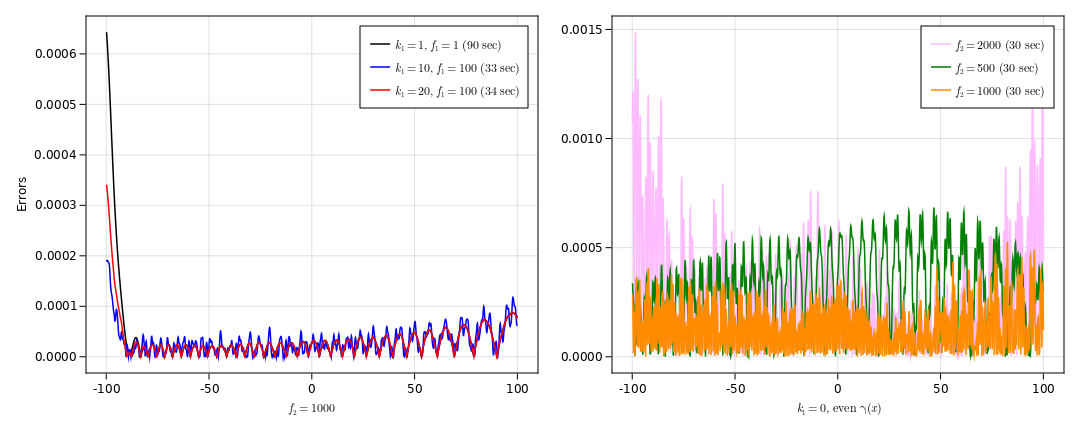

In [101]:
# CairoMakie 2 plots
size_inches = (15, 6)
size_pt = 72 .* size_inches
fig = Figure(resolution = size_pt, fontsize = 12, backgroundcolor = :transparent)
ax1 = Axis(fig[1,1], xlabel = L"f_2 = 1000", ylabel = "Errors")
lines!(ax1, x_vals, set1, label = L"k_1 = 1,\; f_1 = 1 \; (\mathrm{90\;sec})", color = :black)
lines!(ax1, x_vals, set2, label = L"k_1 = 10,\; f_1 = 100 \; (\mathrm{33\;sec})", color = :blue)
lines!(ax1, x_vals, set3, label = L"k_1 = 20,\; f_1 = 100 \; (\mathrm{34\;sec})", color = :red)
#lines!(ax1, x_vals, set7, label = L"k_1 = 100,\; f_1 = 400", color = :red)
axislegend()
ax2 = Axis(fig[1,2], xlabel = L"k_1 = 0, \; \mathrm{even} \; \gamma(x)")
lines!(ax2, x_vals, set6, label = L"f_2 = 2000 \; (\mathrm{30\;sec})", color = :plum1)
lines!(ax2, x_vals, set4, label = L"f_2 = 500 \; (\mathrm{30\;sec})", color = :green)
lines!(ax2, x_vals, set5, label = L"f_2 = 1000 \; (\mathrm{30\;sec})", color = :darkorange)
axislegend()
linkaxes!(ax1,ax2)
#hideydecorations!(ax2, grid = false)

fig
#save("diffparams2.pdf", fig, pt_per_unit = 1)

In [110]:
# CairoMakie 2 plots
size_inches = (15, 6)
size_pt = 72 .* size_inches
fig = Figure(resolution = size_pt, fontsize = 12, backgroundcolor = :transparent)
ax1 = Axis(fig[1,1], xlabel = L"f_2 = 1000", ylabel = "Errors")
lines!(ax1, x_vals, set1, label = L"k_1 = 1,\; f_1 = 1 \; (\mathrm{90\;sec})", color = :black)
lines!(ax1, x_vals, set2, label = L"k_1 = 10,\; f_1 = 100 \; (\mathrm{33\;sec})", color = :blue)
lines!(ax1, x_vals, set3, label = L"k_1 = 20,\; f_1 = 100 \; (\mathrm{34\;sec})", color = :red)
#lines!(ax1, x_vals, set7, label = L"k_1 = 100,\; f_1 = 400", color = :red)
axislegend()
ax2 = Axis(fig[1,2], xlabel = L"k_1 = 0, \; \mathrm{even} \; \gamma(x)")
lines!(ax2, x_vals, set6, label = L"f_2 = 2000 \; (\mathrm{30\;sec})", color = :plum1)
lines!(ax2, x_vals, set4, label = L"f_2 = 500 \; (\mathrm{30\;sec})", color = :green)
lines!(ax2, x_vals, set5, label = L"f_2 = 1000 \; (\mathrm{30\;sec})", color = :darkorange)
axislegend()
CairoMakie.linkyaxes!(ax1,ax2)
#hideydecorations!(ax2, grid = false)

fig
save("diffparams3.pdf", fig, pt_per_unit = 1)

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x0000000093a95130, 1080.0, 432.0, IOContext(IOStream(<file C:\Users\annie\Dropbox\ArtificialBoundaryConditions\diffparams3.pdf>)))
